# Sessa Empirical Estimator Analysis

This notebook implements the Sessa Empirical Estimator (SEE) for estimating prescription durations using two different clustering algorithms:

1. K‑Means Clustering (original approach)
2. DBSCAN Clustering (alternative approach)

For each approach, we analyze two medication categories (e.g., medA and medB) using the dataset in `data/med_events.csv`.

### 1. Import Libraries

In [84]:
# necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# clustering and metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# density estimation and ECDF computation
from scipy.stats import cumfreq, gaussian_kde


# filter warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### 2. Load Data

In [85]:
# Load the dataset from the CSV file
df = pd.read_csv("data/med_events.csv")
print("Data loaded:")
print(df.head())

Data loaded:
   PATIENT_ID        DATE  PERDAY CATEGORY  DURATION
0           1  04/26/2033       4     medA        50
1           1  07/04/2033       4     medB        30
2           1  08/03/2033       4     medB        30
3           1  08/17/2033       4     medB        30
4           1  10/13/2033       4     medB        30


- The dataset will have the following columns: PATIENT_ID, DATE, PERDAY, CATEGORY, DURATION.

### 3. Utility Function: ECDF Using SciPy

In [86]:
def ecdf(data):
    data = np.asarray(data)
    # Using number of bins equal to the length of data for high resolution.
    res = cumfreq(data, numbins=len(data))
    # Calculate bin centers
    x = res.lowerlimit + np.linspace(0, res.binsize * len(res.cumcount), len(res.cumcount))
    y = res.cumcount / len(data)
    return x, y



### 4. SEE Estimator Functions (k-means & DBSCAN)


##### 4.1 Using k-means clustering:

In [87]:
def see_estimator(category, df):
    # Filter data by medication category
    df_cat = df[df['CATEGORY'] == category].copy()
    df_cat['DATE'] = pd.to_datetime(df_cat['DATE'], format='%m/%d/%Y')
    df_cat.sort_values(by=['PATIENT_ID', 'DATE'], inplace=True)
    
    # Compute previous prescription date per patient
    df_cat['prev_DATE'] = df_cat.groupby('PATIENT_ID')['DATE'].shift(1)
    df_sample = df_cat.dropna(subset=['prev_DATE']).copy()
    
    # Randomly sample one consecutive pair per patient
    df_sample = df_sample.groupby('PATIENT_ID').apply(lambda x: x.sample(1, random_state=1234)).reset_index(drop=True)
    df_sample = df_sample[['PATIENT_ID', 'DATE', 'prev_DATE']].copy()
    
    # Compute event intervals in days
    df_sample['event_interval'] = (df_sample['DATE'] - df_sample['prev_DATE']).dt.days.astype(float)
    
    # Compute the ECDF
    x_ecdf, y_ecdf = ecdf(df_sample['event_interval'].values)
    df_ecdf = pd.DataFrame({'x': x_ecdf, 'y': y_ecdf})
    
    # Plot ECDFs (80% and 100%) with category labels
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    ni = df_ecdf_80['x'].max()
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf_80['x'], df_ecdf_80['y'], marker='.', linestyle='none')
    plt.title(f'80% ECDF ({category})')
    plt.xlabel('Event Interval (days)')
    plt.ylabel('ECDF')
    
    plt.subplot(1, 2, 2)
    plt.plot(df_ecdf['x'], df_ecdf['y'], marker='.', linestyle='none')
    plt.title(f'100% ECDF ({category})')
    plt.xlabel('Event Interval (days)')
    plt.ylabel('ECDF')
    plt.tight_layout()
    plt.show()
    
    # Filter sampled intervals less than or equal to ni
    df_filtered = df_sample[df_sample['event_interval'] <= ni].copy()
    
    # Density estimation on log-transformed intervals
    log_intervals = np.log(df_filtered['event_interval'])
    kde = gaussian_kde(log_intervals)
    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)
    
    plt.figure()
    plt.plot(x1, y1)
    plt.title(f'Density of log(event_interval) ({category})')
    plt.xlabel('log(Event Interval)')
    plt.ylabel('Density')
    plt.show()
    
    # Silhouette Analysis
    silhouette_scores = []
    k_values = range(2, 11)
    a = np.column_stack((x1, y1))
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a)
    for k in k_values:
        kmeans_temp = KMeans(n_clusters=k, random_state=1234)
        labels = kmeans_temp.fit_predict(a_scaled)
        score = silhouette_score(a_scaled, labels)
        silhouette_scores.append(score)
    
    plt.figure()
    plt.plot(list(k_values), silhouette_scores, marker='o')
    plt.title(f'Silhouette Analysis for {category}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(list(k_values))
    plt.show()
    
    best_k = k_values[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters (silhouette analysis) for {category}: {best_k}")
    
    # K-Means clustering on ECDF x-values
    kmeans_final = KMeans(n_clusters=best_k, random_state=1234)
    df_ecdf['cluster'] = kmeans_final.fit_predict(df_ecdf[['x']])
    
    # Calculate cluster stats on log(x)
    cluster_stats = df_ecdf.groupby('cluster')['x'].agg(
        min_log=lambda x: np.log(x).min(),
        max_log=lambda x: np.log(x).max(),
        median_log=lambda x: np.log(x).median()
    ).reset_index()
    cluster_stats['Minimum'] = np.exp(cluster_stats['min_log'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max_log'])
    cluster_stats['Median'] = np.exp(cluster_stats['median_log'])
    cluster_stats = cluster_stats[cluster_stats['Median'] > 0]
    
    print("K-Means Cluster Statistics:")
    print(cluster_stats[['cluster', 'Minimum', 'Maximum', 'Median']])
    
    # Assign cluster based on event_interval boundaries
    def assign_cluster(interval):
        for _, row in cluster_stats.iterrows():
            if interval >= row['Minimum'] and interval <= row['Maximum']:
                return row['cluster']
        return np.nan
    
    df_sample['Final_cluster'] = df_sample['event_interval'].apply(assign_cluster)
    df_sample = df_sample.dropna(subset=['Final_cluster']).copy()
    
    # Merge cluster median (estimated duration)
    df_sample = df_sample.merge(cluster_stats[['cluster', 'Median']], left_on='Final_cluster', right_on='cluster', how='left', suffixes=('', '_cluster'))
    if not df_sample.empty:
        most_freq_cluster = df_sample['Final_cluster'].value_counts().idxmax()
        default_median = cluster_stats.loc[cluster_stats['cluster'] == most_freq_cluster, 'Median'].values[0]
    else:
        default_median = np.nan
    
    df_sample['Median_est'] = df_sample['Median'].fillna(default_median)
    df_result = df_cat.merge(df_sample[['PATIENT_ID', 'Median_est', 'Final_cluster']], on='PATIENT_ID', how='left')
    df_result['Median_est'] = df_result['Median_est'].fillna(default_median)
    df_result['Final_cluster'] = df_result['Final_cluster'].fillna(0)
    
    return df_result


##### 4.2 Using DBSCAN clustering:

In [88]:
def see_estimator_dbscan(category, df, eps=None, min_samples=5):
    df_cat = df[df['CATEGORY'] == category].copy()
    df_cat['DATE'] = pd.to_datetime(df_cat['DATE'], format='%m/%d/%Y')
    df_cat.sort_values(by=['PATIENT_ID', 'DATE'], inplace=True)
    df_cat['prev_DATE'] = df_cat.groupby('PATIENT_ID')['DATE'].shift(1)
    df_sample = df_cat.dropna(subset=['prev_DATE']).copy()
    df_sample = df_sample.groupby('PATIENT_ID').apply(lambda x: x.sample(1, random_state=1234)).reset_index(drop=True)
    df_sample = df_sample[['PATIENT_ID', 'DATE', 'prev_DATE']].copy()
    df_sample['event_interval'] = (df_sample['DATE'] - df_sample['prev_DATE']).dt.days.astype(float)
    
    x_ecdf, y_ecdf = ecdf(df_sample['event_interval'].values)
    df_ecdf = pd.DataFrame({'x': x_ecdf, 'y': y_ecdf})
    
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    ni = df_ecdf_80['x'].max()
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf_80['x'], df_ecdf_80['y'], marker='.', linestyle='none')
    plt.title(f'80% ECDF ({category})')
    plt.xlabel('Event Interval (days)')
    plt.ylabel('ECDF')
    
    plt.subplot(1, 2, 2)
    plt.plot(df_ecdf['x'], df_ecdf['y'], marker='.', linestyle='none')
    plt.title(f'100% ECDF ({category})')
    plt.xlabel('Event Interval (days)')
    plt.ylabel('ECDF')
    plt.tight_layout()
    plt.show()
    
    df_filtered = df_sample[df_sample['event_interval'] <= ni].copy()
    log_intervals = np.log(df_filtered['event_interval'])
    kde = gaussian_kde(log_intervals)
    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)
    
    plt.figure()
    plt.plot(x1, y1)
    plt.title(f'Density of log(event_interval) ({category}) [DBSCAN]')
    plt.xlabel('log(Event Interval)')
    plt.ylabel('Density')
    plt.show()
    
    X = df_ecdf['x'].values.reshape(-1, 1)
    if eps is None:
        eps = 0.1 * (X.max() - X.min())
    print(f"Using DBSCAN with eps={eps}, min_samples={min_samples} for {category}")
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X)
    df_ecdf['cluster'] = dbscan_labels
    
    # Remove noise (label -1)
    df_ecdf_clustered = df_ecdf[df_ecdf['cluster'] != -1].copy()
    if df_ecdf_clustered.empty:
        print(f"No clusters found by DBSCAN for {category}.")
        return df_cat.assign(Median_est=np.nan, Final_cluster=-1)
    
    cluster_stats = df_ecdf_clustered.groupby('cluster')['x'].agg(
        min_log=lambda x: np.log(x).min(),
        max_log=lambda x: np.log(x).max(),
        median_log=lambda x: np.log(x).median()
    ).reset_index()
    cluster_stats['Minimum'] = np.exp(cluster_stats['min_log'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max_log'])
    cluster_stats['Median'] = np.exp(cluster_stats['median_log'])
    cluster_stats = cluster_stats[cluster_stats['Median'] > 0]
    
    print("DBSCAN Cluster Statistics:")
    print(cluster_stats[['cluster', 'Minimum', 'Maximum', 'Median']])
    
    def assign_cluster_dbscan(interval):
        for _, row in cluster_stats.iterrows():
            if interval >= row['Minimum'] and interval <= row['Maximum']:
                return row['cluster']
        return np.nan
    
    df_sample['Final_cluster'] = df_sample['event_interval'].apply(assign_cluster_dbscan)
    df_sample = df_sample.dropna(subset=['Final_cluster']).copy()
    
    df_sample = df_sample.merge(cluster_stats[['cluster', 'Median']], left_on='Final_cluster', right_on='cluster', how='left', suffixes=('', '_cluster'))
    if not df_sample.empty:
        most_freq_cluster = df_sample['Final_cluster'].value_counts().idxmax()
        default_median = cluster_stats.loc[cluster_stats['cluster'] == most_freq_cluster, 'Median'].values[0]
    else:
        default_median = np.nan
        
    df_sample['Median_est'] = df_sample['Median'].fillna(default_median)
    df_result = df_cat.merge(df_sample[['PATIENT_ID', 'Median_est', 'Final_cluster']], on='PATIENT_ID', how='left')
    df_result['Median_est'] = df_result['Median_est'].fillna(default_median)
    df_result['Final_cluster'] = df_result['Final_cluster'].fillna(-1)
    
    return df_result


### 5. SEE Assumption Visualization Function


In [89]:
def see_assumption(df):
    # Convert DATE to datetime
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
    
    # Sort data by patient and date
    df_sorted = df.sort_values(by=['PATIENT_ID', 'DATE']).copy()
    
    # Create a sequential prescription number for each patient
    df_sorted['p_number'] = df_sorted.groupby('PATIENT_ID').cumcount() + 1
    
    # Compute the previous date and the duration between prescriptions
    df_sorted['prev_DATE'] = df_sorted.groupby('PATIENT_ID')['DATE'].shift(1)
    df_sorted['Duration'] = (df_sorted['DATE'] - df_sorted['prev_DATE']).dt.days
    
    # Retain only rows where p_number is 2 or more
    df_assump = df_sorted[df_sorted['p_number'] >= 2].copy()
    
    # Compute median duration per patient
    medians_of_medians = df_assump.groupby('PATIENT_ID')['Duration'].median().reset_index(name='median_duration')
    
    # Plot a boxplot of Duration by prescription order with a horizontal line at the overall median
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_assump)
    overall_median = medians_of_medians['median_duration'].median()
    plt.axhline(y=overall_median, linestyle='--', color='red', label=f'Overall median = {overall_median:.1f}')
    plt.title('Duration by Prescription Order')
    plt.xlabel('Prescription Order (p_number)')
    plt.ylabel('Duration (days)')
    plt.legend()
    plt.show()
    
    return plt.gcf()


### 6. Running the Analyses

##### 6.1 Using K-Means Based SEE

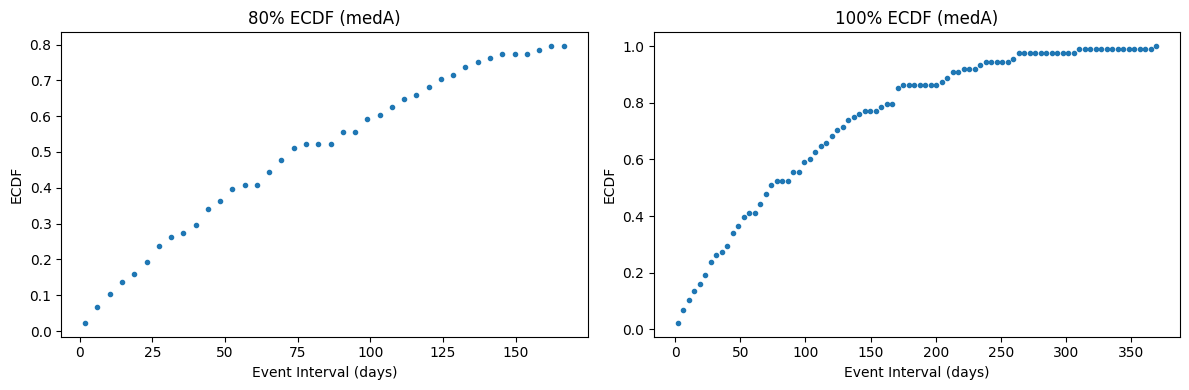

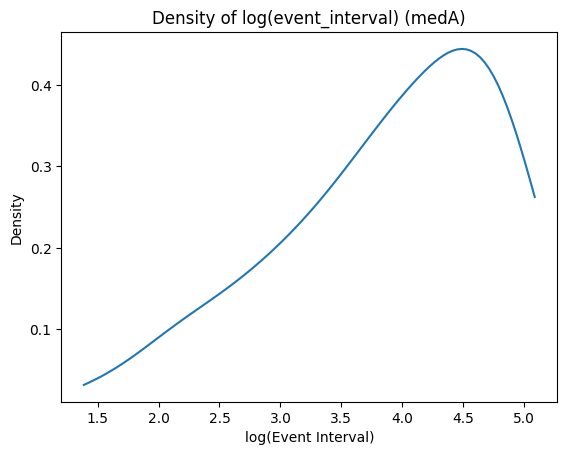

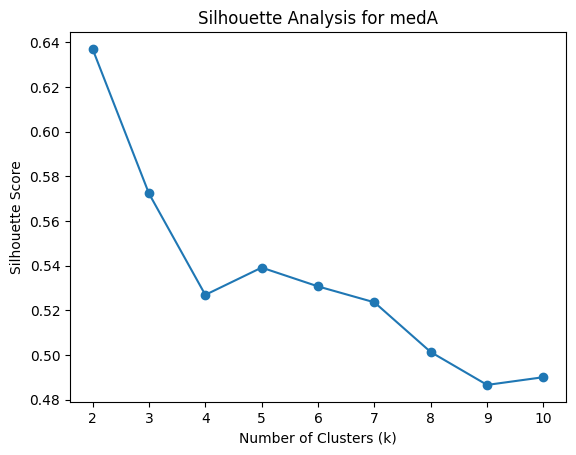

Optimal number of clusters (silhouette analysis) for medA: 2
K-Means Cluster Statistics:
   cluster     Minimum     Maximum      Median
0        0    1.913793  179.169441   90.541617
1        1  183.389814  369.086207  276.238010


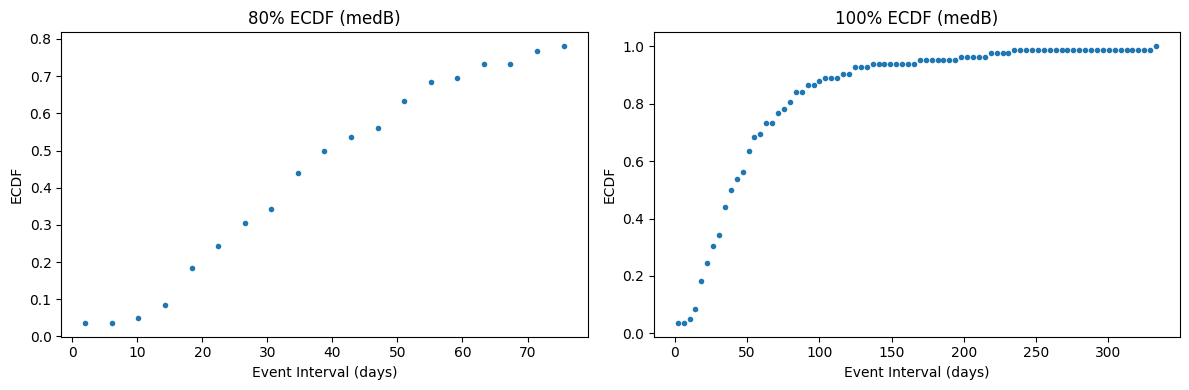

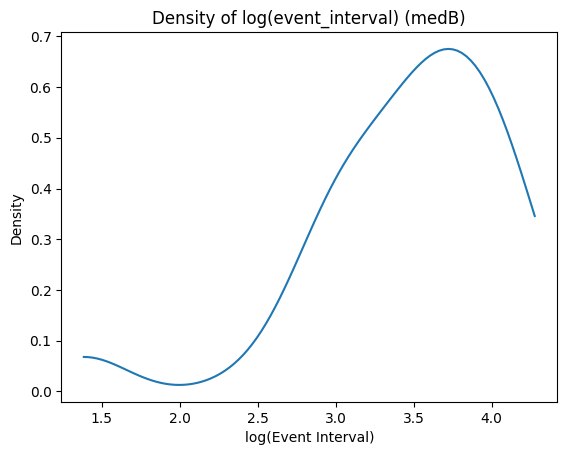

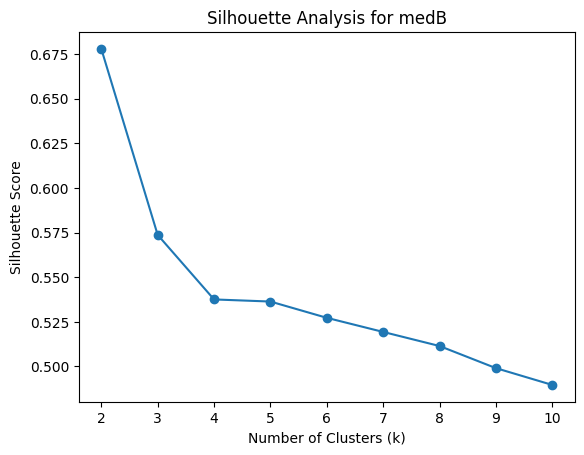

Optimal number of clusters (silhouette analysis) for medB: 2
K-Means Cluster Statistics:
   cluster     Minimum     Maximum      Median
0        0    1.981481  161.369684   81.650017
1        1  165.456561  333.018519  249.229163


In [90]:
# Compute SEE estimates for medA and medB using K-Means
medA_estimates_kmeans = see_estimator("medA", df)
medB_estimates_kmeans = see_estimator("medB", df)


##### 6.2 Using DBSCAN Based SEE

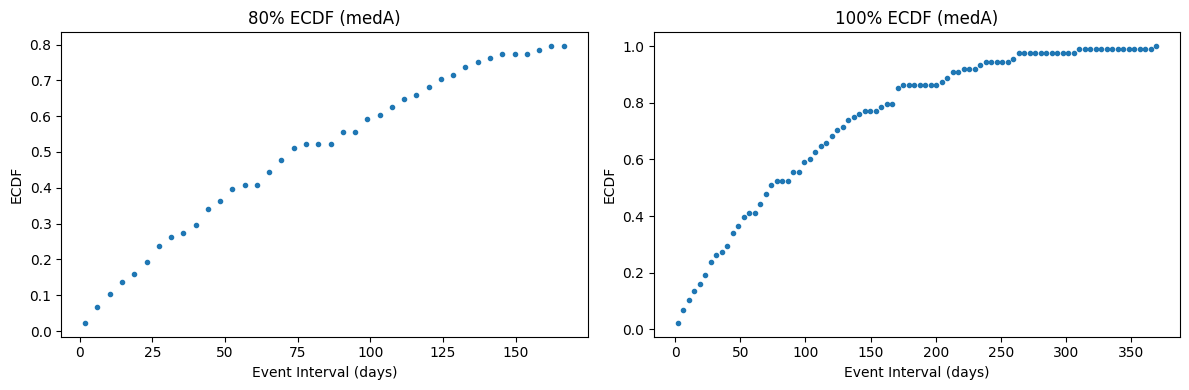

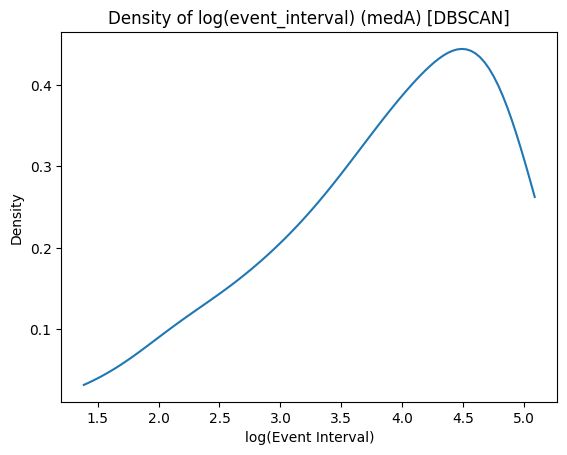

Using DBSCAN with eps=36.71724137931035, min_samples=5 for medA
DBSCAN Cluster Statistics:
   cluster   Minimum     Maximum      Median
0        0  1.913793  369.086207  185.487997


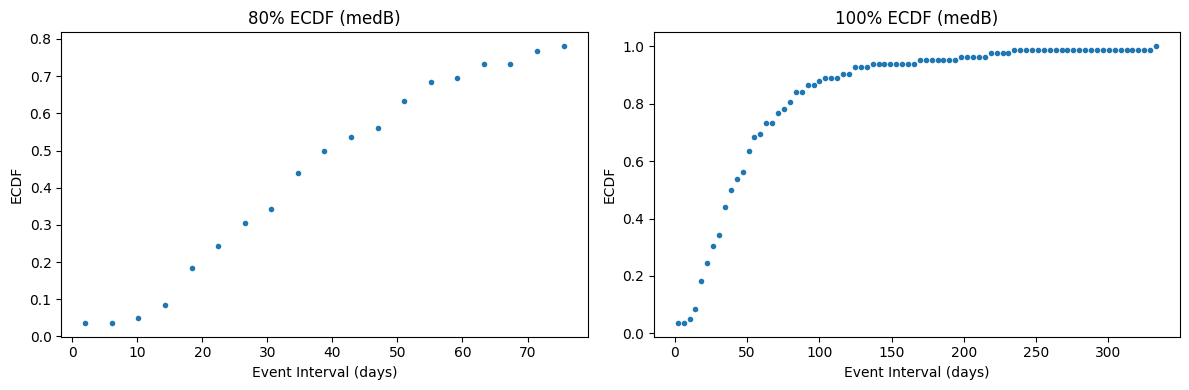

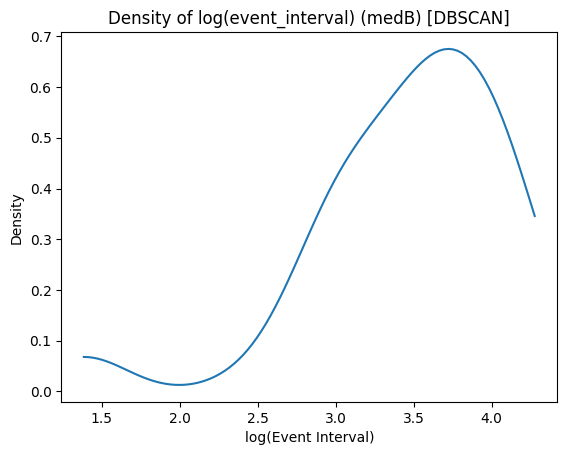

Using DBSCAN with eps=33.103703703703715, min_samples=5 for medB
DBSCAN Cluster Statistics:
   cluster   Minimum     Maximum      Median
0        0  1.981481  333.018519  167.487535


In [91]:
# Compute SEE estimates for medA and medB using DBSCAN
medA_estimates_dbscan = see_estimator_dbscan("medA", df)
medB_estimates_dbscan = see_estimator_dbscan("medB", df)

##### 6.3 Visualizing Assumptions (for entire dataset)

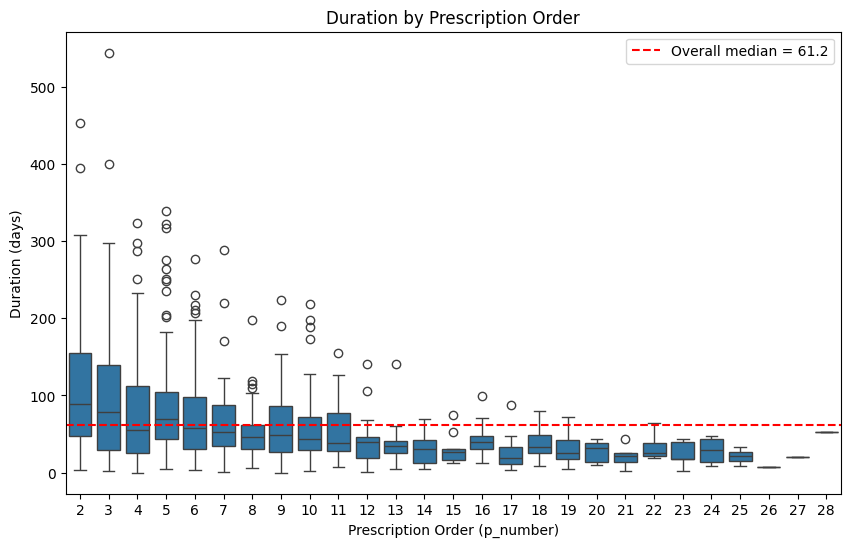

<Figure size 640x480 with 0 Axes>

In [92]:
# Visualize assumption check for the dataset
fig_assumption = see_assumption(df)

### 7. Comparison of Results

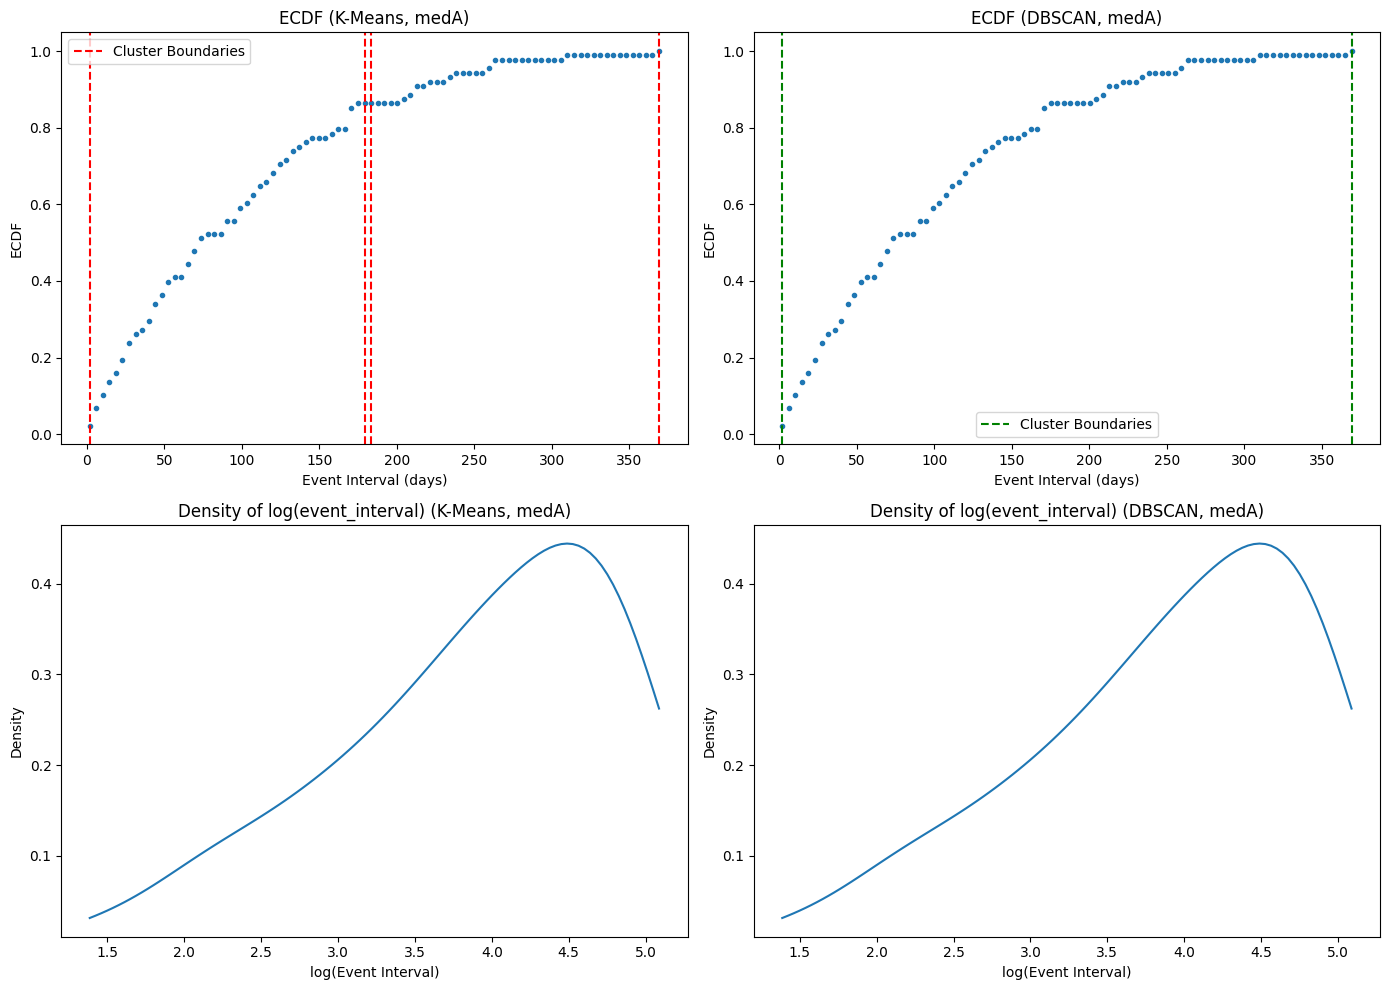

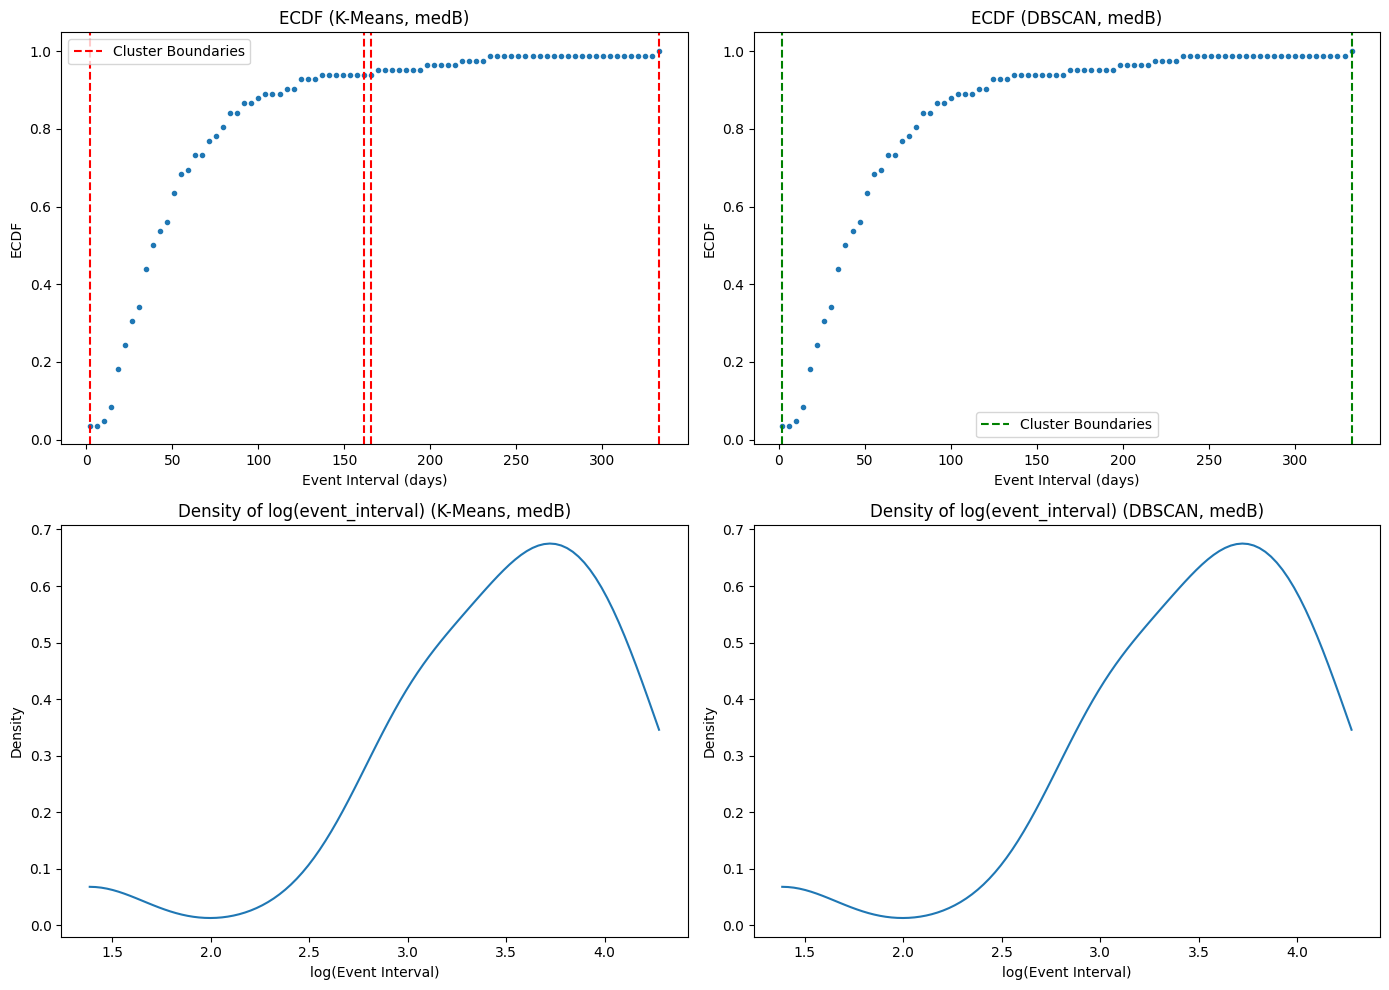

In [ ]:
def compare_cluster_visuals(category, df):
    # Filter data for the given category
    df_cat = df[df['CATEGORY'] == category].copy()
    df_cat['DATE'] = pd.to_datetime(df_cat['DATE'], format='%m/%d/%Y')
    df_cat.sort_values(by=['PATIENT_ID', 'DATE'], inplace=True)
    df_cat['prev_DATE'] = df_cat.groupby('PATIENT_ID')['DATE'].shift(1)
    
    # Keep only rows with a previous prescription date
    df_sample = df_cat.dropna(subset=['prev_DATE']).copy()
    # For each patient, randomly select one pair of consecutive prescriptions
    df_sample = df_sample.groupby('PATIENT_ID').apply(lambda x: x.sample(1, random_state=1234)).reset_index(drop=True)
    df_sample = df_sample[['PATIENT_ID', 'DATE', 'prev_DATE']].copy()
    df_sample['event_interval'] = (df_sample['DATE'] - df_sample['prev_DATE']).dt.days.astype(float)
    
    # Compute ECDF using the ecdf function (defined earlier)
    x_ecdf, y_ecdf = ecdf(df_sample['event_interval'].values)
    df_ecdf = pd.DataFrame({'x': x_ecdf, 'y': y_ecdf})
    # Use lower 80% of the ECDF to define the cutoff
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    ni = df_ecdf_80['x'].max()
    
    # Density estimation on log-transformed event intervals (using only intervals <= ni)
    df_filtered = df_sample[df_sample['event_interval'] <= ni].copy()
    log_intervals = np.log(df_filtered['event_interval'])
    kde = gaussian_kde(log_intervals)
    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)
    
    # --- K-Means Clustering on ECDF x-values ---
    # For illustration, we use best_k = 2 (you may substitute silhouette analysis here)
    best_k = 2
    kmeans = KMeans(n_clusters=best_k, random_state=1234)
    df_ecdf['cluster_km'] = kmeans.fit_predict(df_ecdf[['x']])
    # Compute cluster boundaries for K-Means using log(x)
    cluster_stats_km = df_ecdf.groupby('cluster_km')['x'].agg(
        min_log=lambda x: np.log(x).min(),
        max_log=lambda x: np.log(x).max()
    ).reset_index()
    cluster_stats_km['Minimum'] = np.exp(cluster_stats_km['min_log'])
    cluster_stats_km['Maximum'] = np.exp(cluster_stats_km['max_log'])
    
    # --- DBSCAN Clustering on ECDF x-values ---
    X = df_ecdf['x'].values.reshape(-1, 1)
    eps = 0.1 * (X.max() - X.min())  # Example eps value; adjust as needed
    dbscan = DBSCAN(eps=eps, min_samples=5)
    df_ecdf['cluster_db'] = dbscan.fit_predict(X)
    # Remove noise points (label -1)
    df_ecdf_db = df_ecdf[df_ecdf['cluster_db'] != -1].copy()
    cluster_stats_db = df_ecdf_db.groupby('cluster_db')['x'].agg(
        min_log=lambda x: np.log(x).min(),
        max_log=lambda x: np.log(x).max()
    ).reset_index()
    cluster_stats_db['Minimum'] = np.exp(cluster_stats_db['min_log'])
    cluster_stats_db['Maximum'] = np.exp(cluster_stats_db['max_log'])
    
    # --- Create a 2x2 subplot grid for side-by-side comparisons ---
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # ECDF for K-Means (top left)
    axs[0, 0].plot(df_ecdf['x'], df_ecdf['y'], marker='.', linestyle='none')
    for idx, row in cluster_stats_km.iterrows():
        # Draw vertical lines for the boundaries
        axs[0, 0].axvline(row['Minimum'], color='red', linestyle='--', 
                          label='Cluster Boundaries' if idx==0 else "")
        axs[0, 0].axvline(row['Maximum'], color='red', linestyle='--')
    axs[0, 0].set_title(f'ECDF (K-Means, {category})')
    axs[0, 0].set_xlabel('Event Interval (days)')
    axs[0, 0].set_ylabel('ECDF')
    axs[0, 0].legend()
    
    # ECDF for DBSCAN (top right)
    axs[0, 1].plot(df_ecdf['x'], df_ecdf['y'], marker='.', linestyle='none')
    for idx, row in cluster_stats_db.iterrows():
        axs[0, 1].axvline(row['Minimum'], color='green', linestyle='--', 
                          label='Cluster Boundaries' if idx==0 else "")
        axs[0, 1].axvline(row['Maximum'], color='green', linestyle='--')
    axs[0, 1].set_title(f'ECDF (DBSCAN, {category})')
    axs[0, 1].set_xlabel('Event Interval (days)')
    axs[0, 1].set_ylabel('ECDF')
    axs[0, 1].legend()
    
    # Density plot (log-transformed event intervals) for K-Means (bottom left)
    axs[1, 0].plot(x1, y1)
    axs[1, 0].set_title(f'Density of log(event_interval) (K-Means, {category})')
    axs[1, 0].set_xlabel('log(Event Interval)')
    axs[1, 0].set_ylabel('Density')
    
    # Density plot for DBSCAN (bottom right)
    axs[1, 1].plot(x1, y1)
    axs[1, 1].set_title(f'Density of log(event_interval) (DBSCAN, {category})')
    axs[1, 1].set_xlabel('log(Event Interval)')
    axs[1, 1].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

# Call the function for medA and medB
compare_cluster_visuals('medA', df)
compare_cluster_visuals('medB', df)